<h1><span style="background-color:blue; color:white; padding: 5px;">Entrainment de modèles avec RandomForest Regressor<br></h1>
</h4><span style="background-color:red; color:white; padding: 5px;">Utiliser un outil permettant de rafraîchir la page régulièrement pour éviter la mise en sommeil de MLflow sur Heroku
</span></h4>

In [11]:
import pandas as pd
from functions2 import *

<h2><span style="background-color:grey; color:white; padding: 5px;">Choix des paramètres pour l'entraînement, le stockage sur MLflow et des données à récupérer.</span></h2>

In [46]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [10],
    'min_samples_split': [2]
    }   
cv=5

# Suppression des outliers
supp_outliers=True

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor"

# runs à effectuer all_datas 15months all_datas_surface_terrain 15months_surface_terrain)
run_name = "15months_GridSearch_no_outliers_surface_terrain"
model_name = f"RFR_{run_name}"

# Les filtres de la requête permettent de filtrer les valeurs aberrantes vu dans l'EDA
# et de choisir la plage de données voulu ainsi que les variables
query=f"""
SELECT 
    V.SURFACE_BATI,
    V.ID_COMMUNE,
    V.DATE_MUTATION,
    V.SURFACE_TERRAIN,
    V.MONTANT
FROM VENTES V
INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
WHERE V.MONTANT>15000  AND V.MONTANT<6500000
AND V.SURFACE_BATI>0
AND V.NB_PIECES>0
AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
"""

<h2><span style="background-color:grey; color:white; padding: 5px;">Chargement des données et suppression des outliers. </span></h2>

In [47]:
df = loading_data(query)

#///////////////////////////////////////////////////////////////////////////////
#               Calcul de la limite haute pour enlever les outliers
#///////////////////////////////////////////////////////////////////////////////
if supp_outliers==True :
    q1 = np.percentile(df["MONTANT"], 25)  # Premier quartile (25e percentile)
    q3 = np.percentile(df["MONTANT"], 75)  # Troisième quartile (75e percentile)
    iqr = q3 - q1  # Intervalle interquartile
    # Calcul de la limite supérieure des moustaches
    whisker_upper = q3 + 1.5 * iqr
    # Calcul du nombre de lignes retirées et statistiques
    nb_lignes=df.shape[0]
    nb_sup_moustache = df.loc[df.MONTANT>whisker_upper,:].shape[0]
    print(f"Nombre de ligne avant suppression : {nb_lignes}")
    avant = df.ID_COMMUNE.unique()
    print(f"Nombre de communes avant suppression : {len(avant)}")    
    print(f"Nombre de lignes aberrentes : {nb_sup_moustache}")
    print(f"Pourcentage de lignes exclues :{round(nb_sup_moustache*100/nb_lignes,2)}%")
    print(f"Nombre de communes après suppression : {df.ID_COMMUNE.nunique()}")
    # Suppression des lignes
    df = df.loc[df.MONTANT<=whisker_upper,:]
    apres = df.ID_COMMUNE.unique()
    print(f"Nombre de communes ayant disparues : {len(avant)-len(apres)}")
    print(f"Liste des id communes qui ont disparues : {list(set(avant) ^ set(apres))}")

dupliquees = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {dupliquees}")
df = df.drop_duplicates()

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Nombre de ligne avant suppression : 1205218
Nombre de communes avant suppression : 31749
Nombre de lignes aberrentes : 70346
Pourcentage de lignes exclues :5.84%
Nombre de communes après suppression : 31749
Nombre de communes ayant disparues : 50
Liste des id communes qui ont disparues : ['14743', '24279', '66170', '27330', '83020', '14238', '77518', '21616', '31440', '90016', '24230', '2A197', '24383', '2B231', '41118', '47009', '37190', '32450', '82078', '82175', '60097', '84109', '69212', '39280', '14019', '65107', '09153', '32194', '33210', '14180', '14601', '55195', '31029', '37071', '81006', '33411', '65088', '78406', '78518', '34266', '78620', '09117', '26127', '77452', '13090', '14448', '73299', '82064', '80115', '11204']
Nombre de lignes dupliquées : 112


<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement du modèle et stockage des données avec MLflow. </span></h2>

Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Calcul du prix au m² par commune dans df_train puis ajout dans df_test


Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.2min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.2min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.3min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.2min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.3min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 2.9min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 2.6min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 2.7min


2024/02/15 16:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_mae,split1_test_mae,...,std_test_mae,rank_test_mae,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,73.029618,3.292394,0.829471,0.149730,10,2,50,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-48537.815804,-45282.531296,...,1140.200999,2,0.665894,0.673614,0.678117,0.673269,0.645367,0.667252,0.011624,2
1,161.498855,7.217891,1.793764,0.293887,10,2,100,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-48519.813960,-45268.916862,...,1137.647289,1,0.666157,0.673717,0.678095,0.673325,0.645738,0.667406,0.011491,1


Ré-entraînement avec les meilleurs hyperparamètres en cours...


2024/02/15 16:45:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


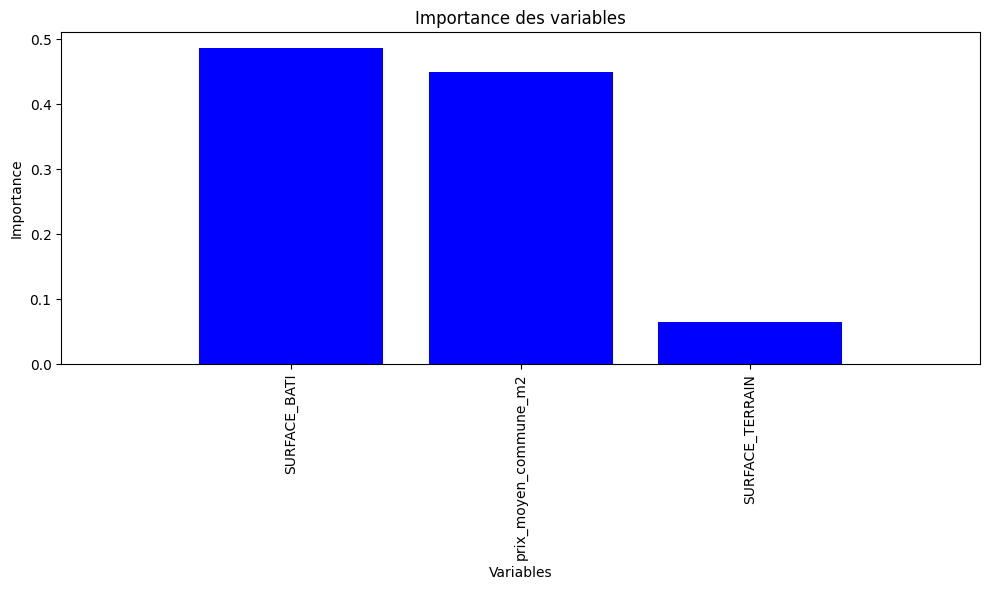

Entraînement OK
Tracé du graphique en cours...


2024/02/15 16:45:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°1 : train score = 0.7185866383372707 -- validation score = 0.6721876848978621


2024/02/15 16:46:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°2 : train score = 0.7022128648941223 -- validation score = 0.6752130611347591


2024/02/15 16:47:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°3 : train score = 0.6958722898959926 -- validation score = 0.6761828973861431


2024/02/15 16:49:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°4 : train score = 0.6911263229156217 -- validation score = 0.67662309833297


2024/02/15 16:50:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°5 : train score = 0.6898209189913909 -- validation score = 0.6768199730487159


2024/02/15 16:52:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°6 : train score = 0.6883792925843119 -- validation score = 0.6771870877811852


2024/02/15 16:54:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°7 : train score = 0.6867612153246911 -- validation score = 0.6774219346360477


2024/02/15 16:57:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°8 : train score = 0.6857747397377483 -- validation score = 0.677387411569639


2024/02/15 17:00:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°9 : train score = 0.6854429875540794 -- validation score = 0.6773889597367144


2024/02/15 17:03:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°10 : train score = 0.6848240501485747 -- validation score = 0.6774246559825922


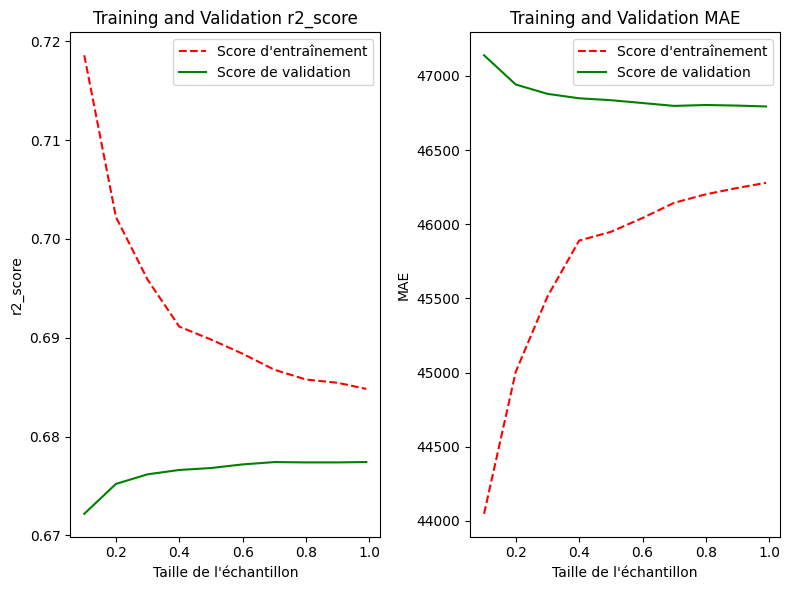

Log du modèle et des artifacts en cours...


Successfully registered model 'RFR_15months_GridSearch_no_outliers_surface_terrain'.
2024/02/15 17:04:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFR_15months_GridSearch_no_outliers_surface_terrain, version 1
Created version '1' of model 'RFR_15months_GridSearch_no_outliers_surface_terrain'.


In [48]:
X_train,y_train, X_test, y_test = split_with_m2(df)

X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

model, best_params, features_importances = train_model_randomforest(X_train,y_train, param_grid, cv)

# Tracé et enregistrement de la learning curve
learning_curve = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

param_mlflow(uri_tracking=uri_tracking,
        experiment_name=experiment_name, run_name=run_name,
        best_params=best_params,
        model=model, model_name=model_name,
        X_test=X_test, y_test=y_test,
        encoders=encoders,scalers=scalers,
        images = [learning_curve, features_importances]).log_mlflow()

Limite supérieure des moustaches : 551275.0


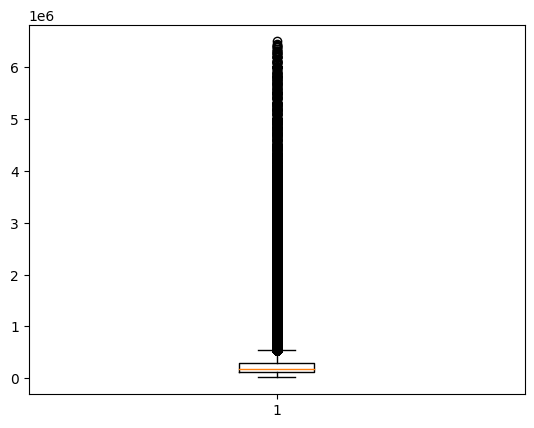

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Création des données fictives
data = df

# Création du boxplot avec Matplotlib
plt.boxplot(data["MONTANT"])

# # Récupération des valeurs des traits de la boîte
# for line in plt.gca().lines:
#     x, y = line.get_xydata()[0]  # Point inférieur gauche de la ligne
#     print(f"Trait de la boîte : {x}, {y}")

# Calcul des statistiques de base
q1 = np.percentile(data["MONTANT"], 25)  # Premier quartile (25e percentile)
q3 = np.percentile(data["MONTANT"], 75)  # Troisième quartile (75e percentile)
iqr = q3 - q1  # Intervalle interquartile

# Calcul de la limite supérieure des moustaches
whisker_upper = q3 + 1.5 * iqr
print("Limite supérieure des moustaches :", whisker_upper)

In [24]:
nb_lignes=df.shape[0]
nb_sup_moustache = df.loc[df.MONTANT>whisker_upper,:].shape[0]
print(f"Nombre de ligne  : {nb_lignes}")
print(f"Nombre de lignes aberrentes : {nb_sup_moustache}")
print(f"Pourcentage de lignes exclues :{round(nb_sup_moustache*100/nb_lignes,2)}%")


Nombre de ligne  : 1205218
Nombre de lignes aberrentes : 70346
Pourcentage de lignes exclues :5.84%
